In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

In [6]:
import tensorflow as tf
visible_devices = tf.config.get_visible_devices()
for devices in visible_devices:
  print(devices)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load dataset

In [7]:
from tensorflow.keras.datasets import mnist

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [13]:
dims = (28*28,1)
n_components = 2
n_neurons = 5
activation = "relu"

In [14]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_neurons, activation=activation),
    tf.keras.layers.Dense(units=n_components),
])

### Create model and train

In [15]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    encoder=encoder,
    dims = dims,
)

In [16]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(dims=(784, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4af14bd3d0>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4ac821cbd0>,
       tensorboard_logdir='/tmp/tensorboard/20210113-145957',
       training_epochs=5)
Construct fuzzy simplicial set
Wed Jan 13 14:59:58 2021 Finding Nearest Neighbors
Wed Jan 13 14:59:58 2021 Building RP forest with 16 trees
Wed Jan 13 14:59:59 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Jan 13 15:00:02 2021 Finished Nearest Neighbor Search
Wed Jan 13 15:00:07 2021 Embedding with TensorFlow


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

batch:   0%|          | 0/7710 [00:00<?, ?it/s]

batch:   0%|          | 0/7710 [00:00<?, ?it/s]

batch:   0%|          | 0/7710 [00:00<?, ?it/s]

batch:   0%|          | 0/7710 [00:00<?, ?it/s]

batch:   0%|          | 0/7710 [00:00<?, ?it/s]

Wed Jan 13 15:04:37 2021 Finished embedding


### Plot model output

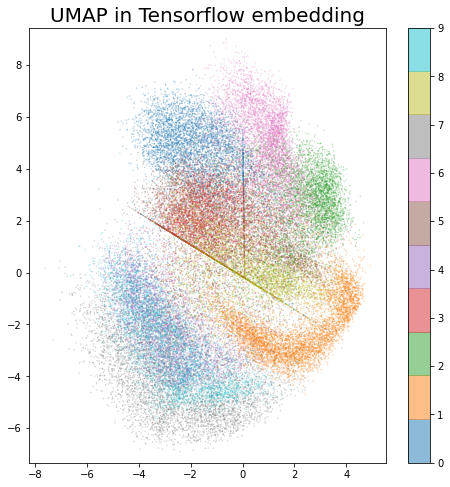

In [17]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [22]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [23]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

,wall_time,step,val,group,variable
0,1.610579e+09,1,1.257749,train,umap_loss
1,1.610579e+09,2,1.185980,train,umap_loss
2,1.610579e+09,3,1.137464,train,umap_loss


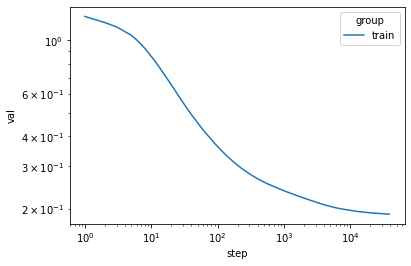

In [24]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')
ax.set_yscale('log')

### Save output

In [ ]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [ ]:
output_dir = MODEL_DIR / 'constrained_projections'/ 'mnist' / 'network'
ensure_dir(output_dir)

In [ ]:
embedder.save(output_dir)

In [ ]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [ ]:
np.save(output_dir / 'z.npy', z)

### Compare to direct embedding with base UMAP

In [ ]:
from umap import UMAP

In [ ]:
z_umap = UMAP(verbose=True).fit_transform(X_train_flat)

In [ ]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);